In [29]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.io import fits
from flareTools import aflare1

import matplotlib as mpl
mpl.rcParams.update({'font.size': 18, 'font.family': 'STIXGeneral', 'mathtext.fontset': 'stix',
                            'image.cmap': 'viridis'})

path = 'subset/'

FINDflare is only marking the middle of flares. This doesnt work well for trying to find the flare energy by integrating under the detected region. Try to figure out something better.

In [6]:
# 1 is a flare, 16 is a spurious detection
df = pd.read_csv('7.gauss.subset.flare_out.csv')
print(len(df))

25


(-0.1, 0.5)

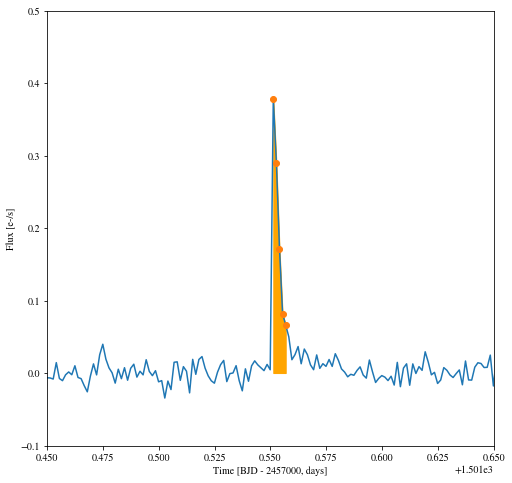

In [28]:
flare_idx = 1
TIC = df.iloc[flare_idx]['TIC']
TIC_str = str(int(TIC)).zfill(16)
file = 'tess2019006130736-s0007-'+TIC_str+'-0131-s_lc.fits'

gp_data_file = file + '.gp'
clean_file = file + '.clean'
param_file = file + '.param'
smo, var = np.loadtxt(path + gp_data_file)
time, flux, flux_error = np.loadtxt(path + clean_file)
median, s_window, acf_1dt = np.loadtxt(path + param_file)

tstart = df.iloc[flare_idx]['t0']
tstop = df.iloc[flare_idx]['t1']

x = time
y = flux/median - smo
yerr = np.sqrt((flux_error/median)**2 + var)

fig, axes = plt.subplots(figsize=(8,8))
axes.plot(x, y)

indices = np.where((time >= tstart) & (time <= tstop))[0]
axes.plot(x[indices], y[indices], 'o')
axes.fill_between(x[indices], 0, y[indices], color='orange')

axes.set_xlabel('Time [BJD - 2457000, days]')
axes.set_ylabel('Flux [e-/s]')
axes.set_xlim(1501.45, 1501.65)
axes.set_ylim(-0.1, 0.5)

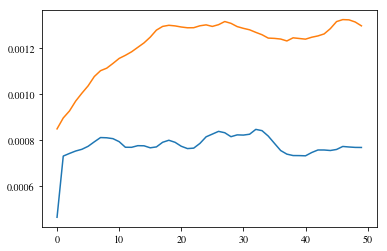

In [27]:
# Start at the center of the flare and expand in each direction

tcenter = (tstop + tstart)/2
istart = np.argwhere(x > tstart)[0]
icenter = np.argwhere(x > tcenter)[0]
istop = np.argwhere(x > tstop)[0]

mask = (x > x[istart]) & (x < x[istop])
ED = np.trapz(y[mask], x[mask])

# Go left
num_iter = 50
delta_ED = np.zeros(num_iter)
for i in range(num_iter):
    istart -= 1
    mask = (x > x[istart]) & (x < x[istop])
    ED_new = np.trapz(y[mask], x[mask])
    delta_ED[i] = ED_new - ED
    
plt.plot(range(num_iter), delta_ED)
    
# Go right
delta_ED = np.zeros(num_iter)
for i in range(num_iter):
    istop += 1
    mask = (x > x[istart]) & (x < x[istop])
    ED_new = np.trapz(y[mask], x[mask])
    delta_ED[i] = ED_new - ED
    
plt.plot(range(num_iter), delta_ED)

Can I make this scale with the duration of the flare? Extend by some number of FWHMs in each direction. Fit a flare model to the data to get the FWHM

[1.50155160e+03 1.62475883e-03 5.87914075e-01]
0.042703105311438


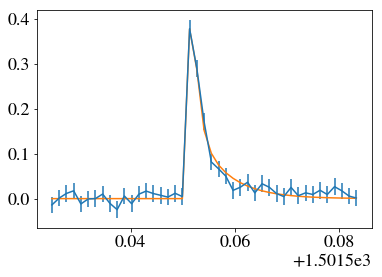

In [32]:
import scipy.stats as stats
from scipy.optimize import curve_fit

def likelihood(y_model, ydata, yerr, dof):
    chi2 = np.sum((ydata - y_model)**2/yerr**2)/dof
    return stats.chi2(dof).pdf(chi2)

dx_fac = 5
dx = tstop - tstart
x1 = tstart - dx*dx_fac
x2 = tstop + dx*dx_fac
mask = (x > x1) & (x < x2)

mu0 = (tstart + tstop)/2
sig0 = (tstop - tstart)/2

popt, pcov = curve_fit(aflare1, x[mask], y[mask], p0=(mu0, sig0, 1), sigma=yerr[mask])
print(popt)
y_model = aflare1(x[mask], popt[0], popt[1], popt[2])

l2 = likelihood(y_model, y[mask], yerr[mask], 3)
print(l2)

plt.errorbar(x[mask], y[mask], yerr[mask])
plt.plot(x[mask], y_model)

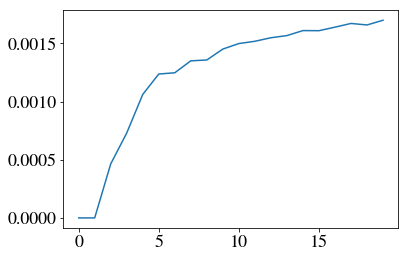

In [48]:
tpeak = popt[0]
fwhm = popt[1]
num_fwhm = 20

ED_vals = np.zeros(num_fwhm)
for i in range(num_fwhm):
    t1 = tpeak - fwhm/2*i
    t2 = tpeak + fwhm/2*i

    mask = (x > t1) & (x < t2)
    ED_vals[i] = np.trapz(y[mask], x[mask])
    
plt.plot(range(num_fwhm), ED_vals)